<a href="https://colab.research.google.com/github/pk2971/computational-gender-analysis/blob/main/notebooks/Token_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import zipfile
import xml.etree.ElementTree as ET
import re
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


In [37]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
zip_path = '/content/drive/MyDrive/debates.zip'
# Clean and parse XML text
def extract_text_from_speech(xml_bytes):
    try:
        root = ET.fromstring(xml_bytes)
        return ' '.join([p.text or '' for p in root.findall('.//speech//p')])
    except ET.ParseError:
        return ""

In [40]:
def get_year_from_filename(filename):
    match = re.search(r'debates(\d{4})', filename)
    return int(match.group(1)) if match else None


In [41]:
def collect_documents_by_year(zip_path, start_year, end_year):
    year_docs = defaultdict(str)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if not file_name.endswith('.xml'):
                continue
            year = get_year_from_filename(file_name)
            if year and start_year <= year <= end_year:
                with zip_ref.open(file_name) as f:
                    xml_bytes = f.read()
                    year_docs[year] += common_utils.extract_text_from_speech(xml_bytes) + " "
    return year_docs

In [42]:
extended_stopwords = [
    # Standard English stopwords (already in NLTK/Scikit-learn)
    # Custom additions:
    "shall", "may", "also", "must", "however", "therefore", "thus", "hereby", "whereas", "therein",
    "thereof", "herein", "therewith", "thereupon", "hereafter", "herewith", "hereupon", "hereinbefore",
    "hereinafter", "hence", "furthermore", "further", "meanwhile", "nevertheless", "nonetheless",
    "notwithstanding", "wherein", "whereby", "whereupon", "whereof", "whilst", "amongst", "upon",
    "whereas", "aforementioned", "said", "such", "one", "two", "three", "four", "five", "six", "seven",
    "eight", "nine", "ten", "first", "second", "third", "forth", "fifth", "sixth", "seventh", "eighth",
    "ninth", "tenth", "mr", "mrs", "ms", "hon", "honourable", "gentleman", "gentlemen", "lady", "lord",
    "member", "members", "committee", "house", "assembly", "parliament", "bill", "act", "motion",
    "debate", "question", "answer", "clause", "subsection", "section", "amendment", "order", "session",
    "speaker", "government", "minister", "secretary", "right", "left", "mr.", "mrs.", "ms.", "hon.",
    "honourable.", "gentleman.", "gentlemen.", "lady.", "lord.", "member.", "members.", "committee.",
    "house.", "assembly.", "parliament.", "bill.", "act.", "motion.", "debate.", "question.", "answer.",
    "clause.", "subsection.", "section.", "amendment.", "order.", "session.", "speaker.", "government",
    "minister.", "secretary",
    # Modal verbs, formalities, and filler words
    "would", "could", "should", "might", "can", "will", "do", "does", "did", "done", "being", "having",
    "make", "made", "take", "taken", "give", "given", "get", "got", "go", "going", "say", "said", "come",
    "came", "see", "seen", "think", "thought", "know", "known", "let", "lets", "much", "many", "few",
    "several", "any", "every", "each", "other", "others", "another", "more", "most", "some", "anyone",
    "anything", "everyone", "everything", "none", "nothing", "always", "never", "sometimes", "often",
    "already", "yet", "still", "just", "even", "ever", "back", "forward", "again", "new", "old",
    "whether","put","cannot","like","though","asked",

    # Numbers as words
    "zero", "hundred", "thousand", "million", "billion", "trillion"]


In [43]:
def get_top_tfidf_words(zip_path, year_input, top_n=20, extra_stopwords=[]):
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # Prepare stopwords
    stop_words = list(set(stopwords.words('english')).union(set(extra_stopwords)).union(set(extended_stopwords)))

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get top words for each year
    for idx, year in enumerate(years):
        tfidf_scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_words = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
        print(f"\nTop words for {year}:")
        for word, score in top_words:
            print(f"{word}: {score:.4f}")

In [35]:
get_top_tfidf_words('/content/drive/MyDrive/debates.zip', 1919, top_n=50, extra_stopwords=["000"])



Top words for 1919:
war: 0.2260
country: 0.2133
time: 0.1820
friend: 0.1750
men: 0.1748
great: 0.1655
us: 0.1231
present: 0.1222
matter: 0.1198
people: 0.1187
state: 0.1150
board: 0.1089
case: 0.1040
trade: 0.1028
regard: 0.0990
work: 0.0977
part: 0.0959
point: 0.0954
way: 0.0949
day: 0.0930
view: 0.0896
whole: 0.0866
years: 0.0846
hope: 0.0842
quite: 0.0827
far: 0.0799
local: 0.0798
possible: 0.0791
man: 0.0781
service: 0.0781
want: 0.0780
position: 0.0778
land: 0.0778
general: 0.0768
last: 0.0761
public: 0.0745
number: 0.0745
year: 0.0739
fact: 0.0724
british: 0.0712
certain: 0.0710
per: 0.0688
deal: 0.0677
labour: 0.0661
gallant: 0.0648
army: 0.0634
pay: 0.0633
aware: 0.0628
without: 0.0626
money: 0.0622


In [44]:
get_top_tfidf_words('/content/drive/MyDrive/debates.zip', (1939,1945), top_n=50, extra_stopwords=["000"])



Top words for 1939:
time: 0.2081
friend: 0.1818
matter: 0.1616
war: 0.1569
country: 0.1439
case: 0.1347
people: 0.1256
point: 0.1248
view: 0.1196
aware: 0.1136
number: 0.1112
present: 0.1073
great: 0.1073
state: 0.1072
part: 0.1051
last: 0.1047
regard: 0.0976
local: 0.0975
fact: 0.0966
trade: 0.0920
work: 0.0893
us: 0.0886
board: 0.0882
general: 0.0867
statement: 0.0867
position: 0.0858
men: 0.0853
british: 0.0846
possible: 0.0827
sir: 0.0814
authorities: 0.0810
certain: 0.0809
report: 0.0799
prime: 0.0796
day: 0.0789
ask: 0.0779
way: 0.0774
year: 0.0773
information: 0.0772
years: 0.0750
public: 0.0740
hope: 0.0736
cases: 0.0727
consider: 0.0704
service: 0.0684
far: 0.0681
air: 0.0667
whole: 0.0655
department: 0.0651
deal: 0.0643

Top words for 1940:
war: 0.2767
friend: 0.2360
time: 0.1956
matter: 0.1606
country: 0.1514
aware: 0.1394
people: 0.1369
case: 0.1189
state: 0.1152
view: 0.1133
present: 0.1107
point: 0.1098
great: 0.1002
home: 0.0989
work: 0.0984
men: 0.0970
last: 0.0956
par

In [45]:
get_top_tfidf_words('/content/drive/MyDrive/debates.zip', 1928, top_n=50, extra_stopwords=["000"])



Top words for 1928:
country: 0.1886
time: 0.1831
people: 0.1568
great: 0.1469
matter: 0.1281
point: 0.1253
case: 0.1233
industry: 0.1193
year: 0.1166
us: 0.1153
men: 0.1131
present: 0.1120
years: 0.1104
state: 0.1091
work: 0.1055
trade: 0.1045
day: 0.1012
regard: 0.1001
last: 0.0992
number: 0.0955
way: 0.0946
part: 0.0944
local: 0.0917
whole: 0.0911
view: 0.0889
fact: 0.0880
per: 0.0860
friend: 0.0847
certain: 0.0839
position: 0.0813
far: 0.0812
want: 0.0804
board: 0.0803
general: 0.0802
money: 0.0760
public: 0.0752
quite: 0.0752
deal: 0.0729
scheme: 0.0728
report: 0.0728
relief: 0.0712
british: 0.0698
man: 0.0680
hope: 0.0679
ask: 0.0678
health: 0.0660
scotland: 0.0655
find: 0.0651
authorities: 0.0649
ought: 0.0641


In [46]:
get_top_tfidf_words('/content/drive/MyDrive/debates.zip', (2022,2024), top_n=50, extra_stopwords=["000"])



Top words for 2022:
people: 0.3352
friend: 0.2071
support: 0.1667
need: 0.1541
time: 0.1513
uk: 0.1460
work: 0.1388
us: 0.1315
country: 0.1199
state: 0.1127
want: 0.1041
years: 0.1038
year: 0.1029
important: 0.0992
way: 0.0976
local: 0.0969
across: 0.0925
point: 0.0923
prime: 0.0876
public: 0.0872
today: 0.0852
ensure: 0.0846
place: 0.0835
energy: 0.0817
last: 0.0797
well: 0.0733
thank: 0.0731
help: 0.0720
home: 0.0699
part: 0.0679
issue: 0.0676
children: 0.0674
working: 0.0663
health: 0.0660
world: 0.0656
good: 0.0648
sure: 0.0622
agree: 0.0609
look: 0.0608
services: 0.0603
long: 0.0599
ireland: 0.0588
clear: 0.0587
care: 0.0585
national: 0.0578
ukraine: 0.0576
northern: 0.0573
constituents: 0.0572
including: 0.0567
party: 0.0564

Top words for 2023:
people: 0.3231
friend: 0.1982
support: 0.1682
work: 0.1640
uk: 0.1558
need: 0.1461
time: 0.1389
us: 0.1224
year: 0.1207
state: 0.1164
years: 0.1102
country: 0.1062
want: 0.1023
important: 0.0999
ensure: 0.0966
public: 0.0943
way: 0.0941


In [ ]:
def plot_word_importance(zip_path, word, year_input, extra_stopwords=[]):
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Collect documents by year
    year_docs = collect_documents_by_year(zip_path, start_year, end_year)
    years = sorted(year_docs.keys())
    documents = [year_docs[year] for year in years]

    # Prepare stopwords
    stop_words = list(set(stopwords.words('english')).union(set(extra_stopwords).union(set(extended_stopwords))))

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    # Get importance of the word for each year
    word = word.lower()
    if word not in feature_names:
        print(f"'{word}' not found in the vocabulary.")
        return

    word_idx = list(feature_names).index(word)
    importances = tfidf_matrix[:, word_idx].toarray().flatten()

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(years, importances, marker='o', linestyle='-', color='b')
    plt.title(f"TF-IDF Importance of '{word}' from {years[0]} to {years[-1]}")
    plt.xlabel("Year")
    plt.ylabel("TF-IDF Importance")
    plt.grid(True)
    plt.xticks(years)
    plt.show()


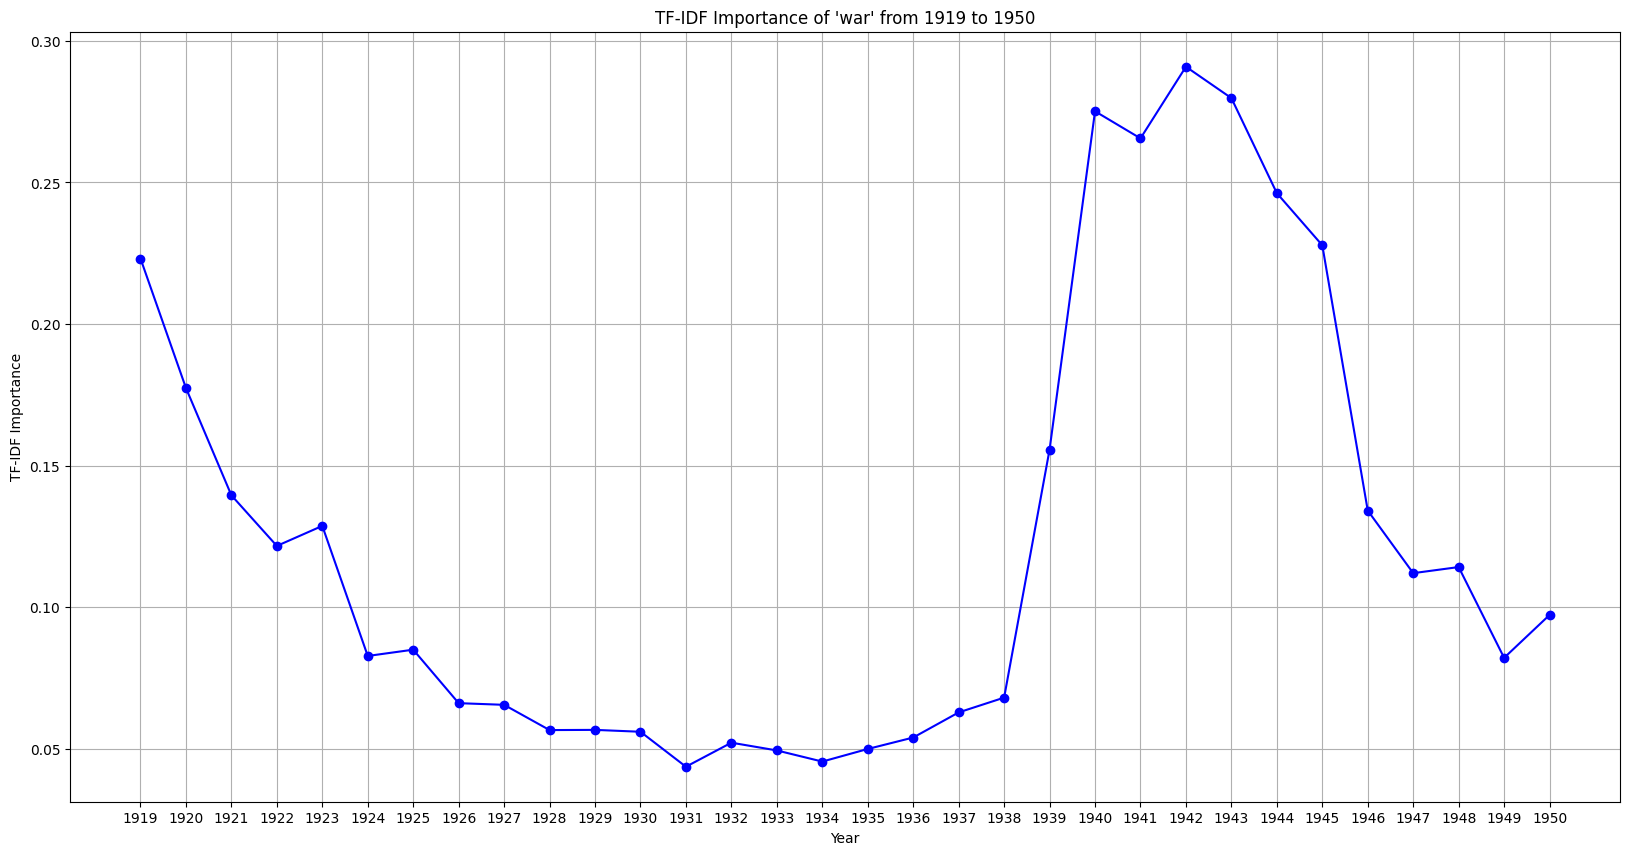

In [ ]:
plot_word_importance('/content/drive/MyDrive/debates.zip', 'war', (1919, 1950), extra_stopwords=["shall", "may", "also"])


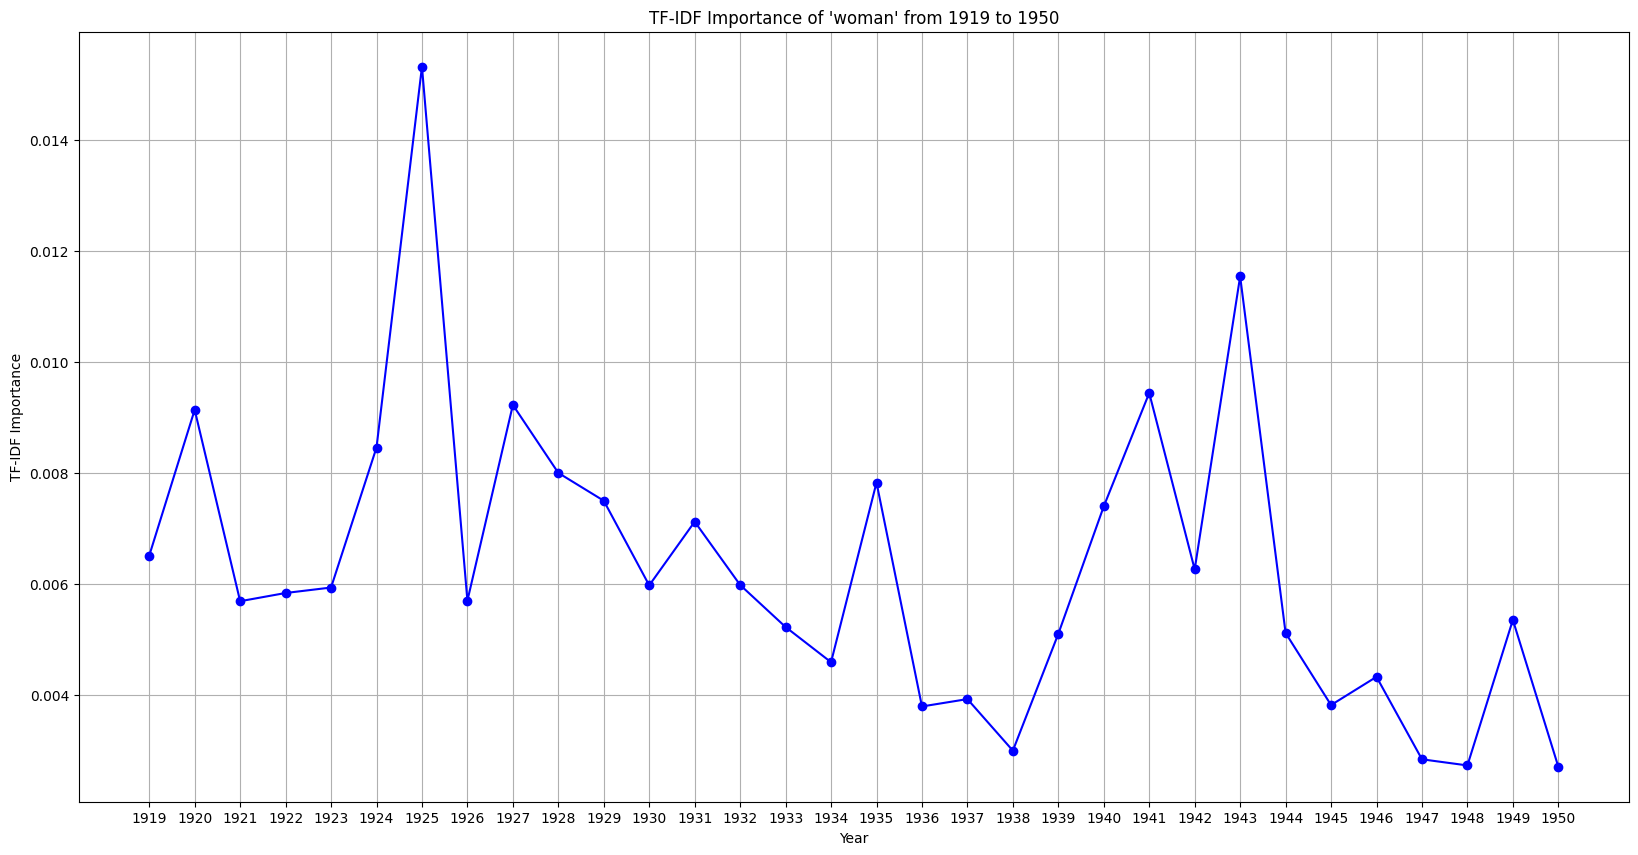

In [ ]:
plot_word_importance('/content/drive/MyDrive/debates.zip', 'woman', (1919, 1950), extra_stopwords=["shall", "may", "also"])
